# Template for ADCP & Surface/Bottom Velocity Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from airsea.windstress import stress
from matplotlib import mlab
import scipy.signal as signal
import scipy.stats as st
from scipy.interpolate import interp1d
from scipy import arange, array, exp, integrate
from physoce import tseries as ts
import gsw

def neureg(x,y):
    #x,y are numpy arrays
    #subtract mean to make zero mean:
    xn = x - np.mean(x)
    yn = y - np.mean(y)
    #perform neutral regression for comparison, e.g. Garrett and Petrie 1981 and Kirincich et al 2005
    an = np.sqrt(((st.tvar(yn)))/((st.tvar(xn)))) #find slope
    bn = (np.mean(y) - an*np.mean(x)) #find intercept
    rn = np.sum(x*y)/np.sqrt((np.sum(x**2)*np.sum(y**2))) #find correlation coefficient
    slope_err = an*np.sqrt((1-rn**2)/len(x)) #compute std err in slope = a*sqrt((1-r^2)/n)
    #compute std err in intercept = vary^.5*sqrt((1-r^2)/n*(1+xmean^2/var(x))) 
    #(e.g., Miller & Kahn 1962, Statistical Analysis in the Geological Science)
    #https://stats.stackexchange.com/questions/391112/standard-error-of-coefficient-estimates-for-model-ii-regression
    inter_err = np.sqrt(st.tvar(yn))*np.sqrt(((1-rn**2)/len(x))*(1+np.mean(x)**2/st.tvar(xn))) 
    return an,bn,rn,slope_err,inter_err

def extrap1d(interpolator):
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        else:
            return interpolator(x)

    def ufunclike(xs):
        return np.array(list(map(pointwise, np.array(xs))))

    return ufunclike

def rot(u,v,theta):
    w = u + 1j*v
    ang = theta*np.pi/180
    wr = w*np.exp(1j*ang)
    ur = np.real(wr)
    vr = np.imag(wr)
    return ur,vr

def princax(u,v=None):

    # if one input only, decompose complex vector
    if v is None:
        w = np.copy(u)
        u = np.real(w)
        v = np.imag(w)

    # only use finite values for covariance matrix
    ii = np.isfinite(u+v)
    uf = u[ii]
    vf = v[ii]

    # compute covariance matrix
    C = np.cov(uf,vf)

    # calculate principal axis angle (ET, Equation 4.3.23b)
    theta = 0.5*np.arctan2(2.*C[0,1],(C[0,0] - C[1,1])) * 180/np.pi

    # calculate variance along major and minor axes (Equation 4.3.24)
    term1 = C[0,0] + C[1,1]
    term2 = ((C[0,0] - C[1,1])**2 + 4*(C[0,1]**2))**0.5
    major = np.sqrt(0.5*(term1 + term2))
    minor = np.sqrt(0.5*(term1 - term2))

    return theta,major,minor

C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?


## ADCP Data Retrieval
***

### Open ADCP dataset

In [3]:
ncfile = 'C:/Users/asche/REU21/netcdf/merged_velocity_orshelf.nc'
ds = xr.open_dataset(ncfile)
ds.load()
zero = np.zeros(len(ds['time']))

In [4]:
ds

<xarray.Dataset>
Dimensions:                      (bin_depths_avg: 37, time: 17814)
Coordinates:
  * time                         (time) datetime64[ns] 2019-04-20T00:30:00 .....
  * bin_depths_avg               (bin_depths_avg) float64 1.894 9.148 ... 74.6
Data variables:
    depth_from_pressure          (time) float64 80.06 79.97 79.9 ... 81.07 81.13
    sea_surface                  (time) float64 -0.7068 -0.7922 ... 0.3683
    eastward_seawater_velocity   (time, bin_depths_avg) float64 -0.1552 ... 0...
    northward_seawater_velocity  (time, bin_depths_avg) float64 -0.4895 ... 0...
    bin_depths                   (time, bin_depths_avg) float64 1.842 ... 74.98

### Define some variables for convenience

In [5]:
ds['u'] = ds['eastward_seawater_velocity']
ds['u'].attrs['units'] = 'm/s'

ds['v'] = ds['northward_seawater_velocity']
ds['v'].attrs['units'] = 'm/s'

### Go from bins to depths

### Plot and choose good bin depths to use ADCP data for

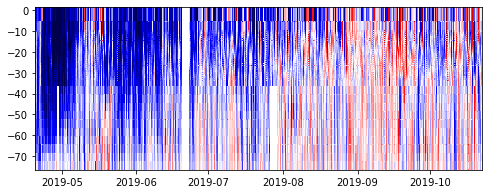

In [64]:
plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],-ds['bin_depths_avg'],ds['u'].T,cmap='seismic', shading='auto')
#plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])

In [ ]:
good = (ds['bin_depths'] > 3)

## Surface/Bottom Data Retrieval and Combination with ADCP Data
***
*Bottom Dataset is still a work in progress analysis*


### Open surface dataset

In [ ]:
ncfile = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-SBD17-04-VELPTA000-telemetered-velpt_ab_dcl_instrument/deployment0011_CE01ISSM-SBD17-04-VELPTA000-telemetered-velpt_ab_dcl_instrument.ncml'
ds_surf = xr.open_dataset(ncfile)
ds_surf.load()

### Open bottom Dataset

In [ ]:
#ncfile = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-MFD35-01-VEL3DD000-recovered_host-vel3d_cd_dcl_velocity_data_recovered/deployment0011_CE01ISSM-MFD35-01-VEL3DD000-recovered_host-vel3d_cd_dcl_velocity_data_recovered.ncml'
#ds_bott = xr.open_dataset(ncfile)
#ds_bott.load()

### Define time range we are interested in

In [10]:
t1 = np.datetime64('2019-05-01 00:00:00')
t2 = np.datetime64('2019-08-01 00:00:00')

### Define some easier-to-use variables

### Put all datasets onto common time dimension 

### If needed, resample surface/bottom data onto time frame compatible with adcp data
(Usually 1 hour or 30 mins)

In [ ]:
#ds_surf.where(good_time).resample(time='1h').mean() 
#ds_bott.where(good_time).resample(time='1h').mean() #really long run time

### Extrapolate constant/linear values for sea surface
*As previously mentioned, the below analysis does not include bottom data yet.*

In [272]:
vel_extrap_type = 1 #linear surface extrap = 0, constant surface extrap = 1
eastintfit = interp1d([ds['bin_depths_avg'].values[0],ds['bin_depths_avg'].values[1]],
                      np.vstack([ds['u'].values.T[0],ds['u'].values.T[1]]), axis=0)
eastextfit = extrap1d(eastintfit) #extrapolation function from https://stackoverflow.com/questions/2745329/how-to-make-scipy-interpolate-give-an-extrapolated-result-beyond-the-input-range
northintfit = interp1d([ds['bin_depths_avg'][0].values,ds['bin_depths_avg'].values[1]],
                      np.vstack([ds['v'].values.T[0],ds['v'].values.T[1]]), axis=0)
northextfit = extrap1d(northintfit)
surf_east_vel =  ds['u'].values.T[0]
surf_north_vel =  ds['v'].values.T[0]
#fill in array with new depths and extrapolated values:
depth_step = 1 #how far apart should extrapolation values be?
depth = ds['bin_depths_avg'].values[1] #start at top bin depth
east_vel_extrap,north_vel_extrap,dep_extrap = [],[],[]
while depth > 0+depth_step: #iterate from top of bin to surface
    depth -= depth_step
    if vel_extrap_type == 0:
        east_vel_extrap.extend(eastextfit([depth]))
        north_vel_extrap.extend(northextfit([depth]))
        dep_extrap.append(depth)
    elif vel_extrap_type == 1:
        east_vel_extrap.append(surf_east_vel)
        north_vel_extrap.append(surf_north_vel)
        dep_extrap.append(depth)
east_vel_extrap = np.array(np.flip(east_vel_extrap, axis=0))
north_vel_extrap = np.array(np.flip(north_vel_extrap, axis=0))
dep_extrap = np.array(np.flip(dep_extrap, axis=0))

# Trasport Fraction Analysis

In [273]:
#only considering subsurface depths from original array
#since unordered bins break nitrate binning
dep_mask = np.where(ds['bin_depths_avg'] > 2)

### Combine adcp and extrapolated data into new arrays

In [274]:
#bin depth dimension for new array, based off aligned values, concatenated with surface buoy depth
new_bin_depth = []
new_bin_depth.extend(dep_extrap)
new_bin_depth.extend(ds['bin_depths_avg'].values[dep_mask])
new_bin_depth = np.array(new_bin_depth)
#time dimension for both buoys, based off aligned values
new_time = []
new_time.extend(ds['time'].values)
new_time = np.array(new_time)
#new variables for east and north velocities
east_vel = []
east_vel.extend(east_vel_extrap)
east_vel.extend(ds['u'].values.T[dep_mask])
east_vel = np.array(east_vel)
north_vel = []
north_vel.extend(north_vel_extrap)
north_vel.extend(ds['v'].values.T[dep_mask])
north_vel = np.array(north_vel)
#some extra necessary variables for the depth averaging
bottom_depth_avg = np.nanmean(ds['depth_from_pressure'].values)
sea_surface = ds['sea_surface'].values

### Combine all these data into a new dataarray for surface data

In [275]:
ds_comb = xr.Dataset()
ds_comb['time'] = new_time
ds_comb['bin_depths_avg'] = new_bin_depth
ds_comb['u'] = (['bin_depths_avg','time'],east_vel)
ds_comb['v'] = (['bin_depths_avg','time'],north_vel)
ds_comb['sea_surface'] = (['time'],sea_surface)
ds_comb['bottom_depth_avg'] = ([],bottom_depth_avg)

In [276]:
ds_comb.load()

<xarray.Dataset>
Dimensions:           (bin_depths_avg: 45, time: 17814)
Coordinates:
  * time              (time) datetime64[ns] 2019-04-20T00:30:00 ... 2019-10-2...
  * bin_depths_avg    (bin_depths_avg) float64 0.1479 1.148 2.148 ... 70.6 74.6
Data variables:
    u                 (bin_depths_avg, time) float64 -0.1552 ... 0.001094
    v                 (bin_depths_avg, time) float64 -0.4895 -0.5444 ... 0.09226
    sea_surface       (time) float64 -0.7068 -0.7922 -0.8673 ... 0.3059 0.3683
    bottom_depth_avg  float64 80.72

## Ensure no obvious errors in velocity analysis with plot!

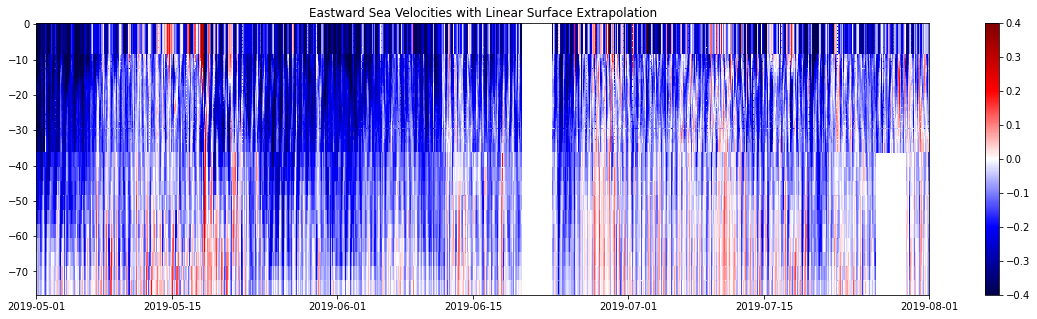

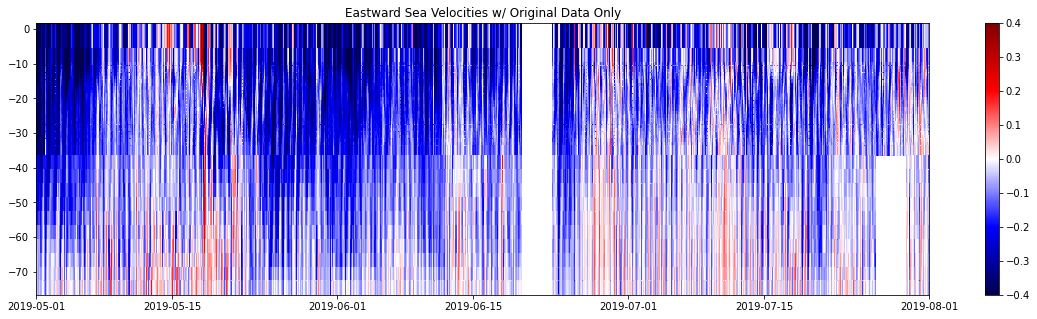

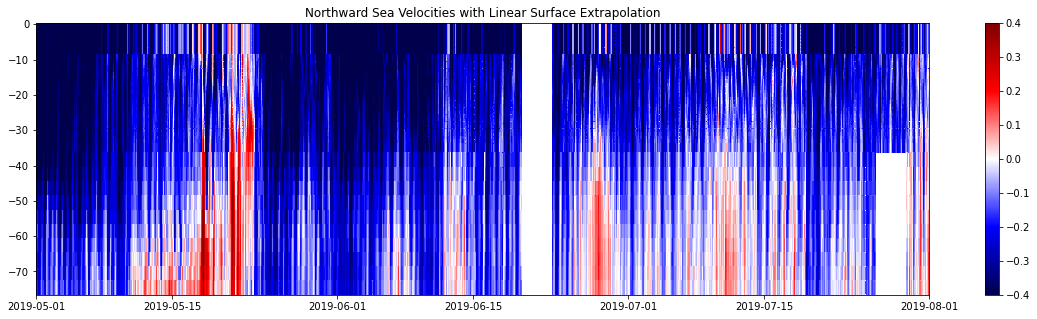

In [279]:
mask = ~np.isnan(ds_comb['bin_depths_avg'].values) #mask to avoid gap in pcolor plot at nan values
plt.figure(figsize=(20,5))
plt.pcolor(ds_comb['time'].values,-ds_comb['bin_depths_avg'].values[mask],ds_comb['u'].values[mask],
           cmap='seismic',shading='auto')
#plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
#plt.ylim([np.min(ds_comb['bin_depths_avg']),0])
plt.xlim([t1,t2])
plt.title('Eastward Sea Velocities with Linear Surface Extrapolation')
plt.colorbar()

plt.figure(figsize=(20,5))
plt.pcolor(ds['time'],-ds['bin_depths_avg'],ds['u'].T,cmap='seismic', shading='auto')
#plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.colorbar()
plt.xlim([t1,t2])
plt.title('Eastward Sea Velocities w/ Original Data Only')

plt.figure(figsize=(20,5))
plt.pcolor(ds_comb['time'].values,-ds_comb['bin_depths_avg'].values[mask],ds_comb['v'].values[mask],
           cmap='seismic',shading='auto')
#plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
#plt.ylim([np.min(ds_comb['bin_depths_avg']),0])
plt.xlim([t1,t2])
plt.title('Northward Sea Velocities with Linear Surface Extrapolation')
plt.colorbar()

## Now perform regular velocity analysis (filtering, depth average, etc.)

### Filter data

In [280]:
temp = xr.DataArray(ts.pl64(ds_comb['u'].T,0.5).T,coords=(ds_comb['bin_depths_avg'],ds_comb['time']),
                    dims=('bin_depths_avg','time'),name='u_fil')
ds_comb = ds_comb.merge(temp)
temp = xr.DataArray(ts.pl64(ds_comb['v'].T,0.5).T,coords=(ds_comb['bin_depths_avg'],ds_comb['time']),
                    dims=('bin_depths_avg','time'),name='v_fil')
ds_comb = ds_comb.merge(temp)

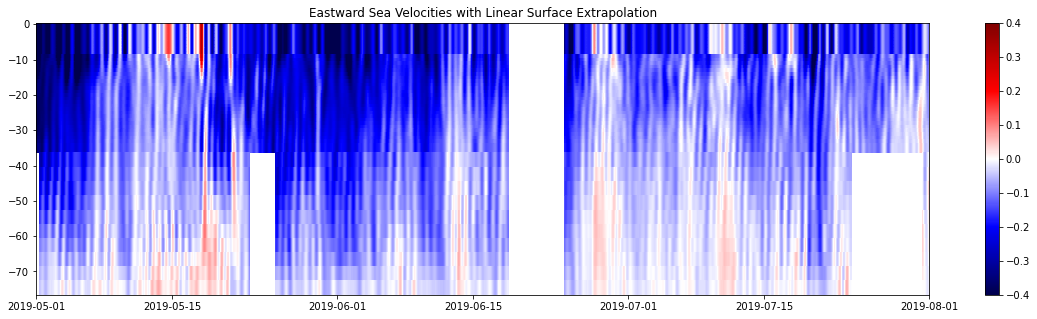

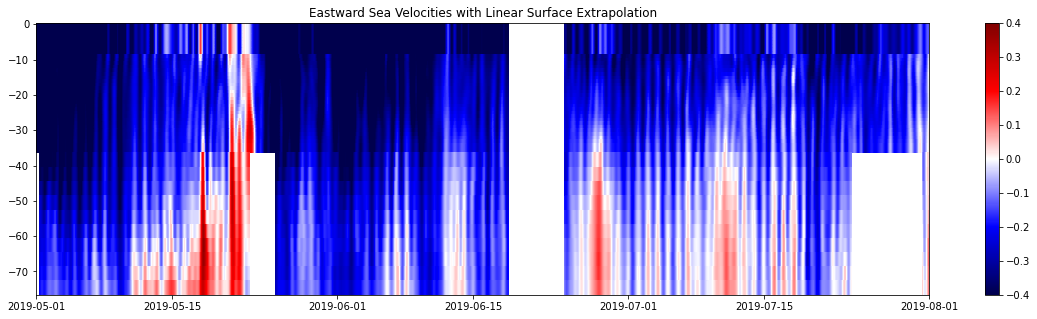

In [281]:
plt.figure(figsize=(20,5))
plt.pcolor(ds_comb['time'],-ds_comb['bin_depths_avg'],
           ds_comb['u_fil'],cmap='seismic',shading='auto')
#plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
#plt.ylim([np.min(ds_comb['bin_depths_avg']),0])
plt.xlim([t1,t2])
plt.title('Eastward Sea Velocities with Linear Surface Extrapolation')
plt.colorbar()

plt.figure(figsize=(20,5))
plt.pcolor(ds_comb['time'],-ds_comb['bin_depths_avg'],
           ds_comb['v_fil'],cmap='seismic',shading='auto')
#plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
#plt.ylim([np.min(ds_comb['bin_depths_avg']),0])
plt.xlim([t1,t2])
plt.title('Eastward Sea Velocities with Linear Surface Extrapolation')
plt.colorbar()

### Perform depth average

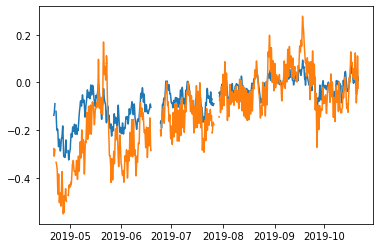

In [282]:
uda = ts.depthavg(ds_comb['u_fil'].T,
                  -ds_comb['bin_depths_avg'],
                  ds_comb['bottom_depth_avg'],
                  ds_comb['sea_surface'])

vda = ts.depthavg(ds_comb['v_fil'].T,
                  -ds_comb['bin_depths_avg'],
                  ds_comb['bottom_depth_avg'],
                  ds_comb['sea_surface'])

ds_comb['uda'] = xr.DataArray(uda,dims='time')
ds_comb['uda'].attrs['units'] = 'm/s'
ds_comb['vda'] = xr.DataArray(vda,dims='time')
ds_comb['vda'].attrs['units'] = 'm/s'

plt.figure()
plt.plot(ds_comb['time'], ds_comb['uda'])
plt.plot(ds_comb['time'], ds_comb['vda'])

### Rotate into principal axis, plot to make sure rotation worked correctly

In [283]:
theta,major,minor = princax(ds_comb['uda'],ds_comb['vda']) 
ds_comb['cs_da'],ds_comb['as_da'] = rot(ds_comb['uda'],ds_comb['vda'],-theta+90)
ds_comb['cs_fil'],ds_comb['as_fil'] = rot(ds_comb['u_fil'],ds_comb['v_fil'],-theta+90)

#save theta for use in other analysis! 
ds_comb['theta'] = ([], theta)

### Subtract depth average

In [284]:
ds_comb['cs_bar'] = ds_comb['cs_fil'] - ds_comb['cs_da']
ds_comb['as_bar'] = ds_comb['as_fil'] - ds_comb['as_da']

### Plot baroclinic velocities

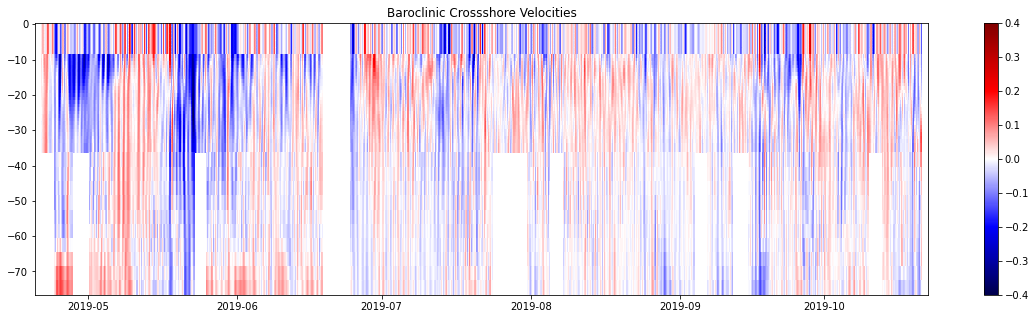

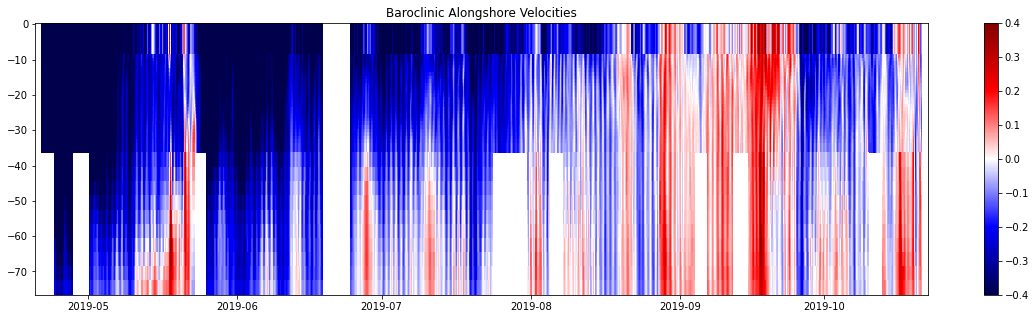

In [285]:
plt.figure(figsize=(20,5))
plt.pcolor(ds_comb['time'],-ds_comb['bin_depths_avg'],
           ds_comb['cs_fil'],cmap='seismic',shading='auto')
plt.clim([-0.4,0.4])
plt.title('Filtered Crossshore Velocities')
plt.colorbar()

plt.figure(figsize=(20,5))
plt.pcolor(ds_comb['time'],-ds_comb['bin_depths_avg'],
           ds_comb['as_fil'],cmap='seismic',shading='auto')
plt.clim([-0.4,0.4])
plt.title('Filtered Alongshore Velocities')
plt.colorbar()

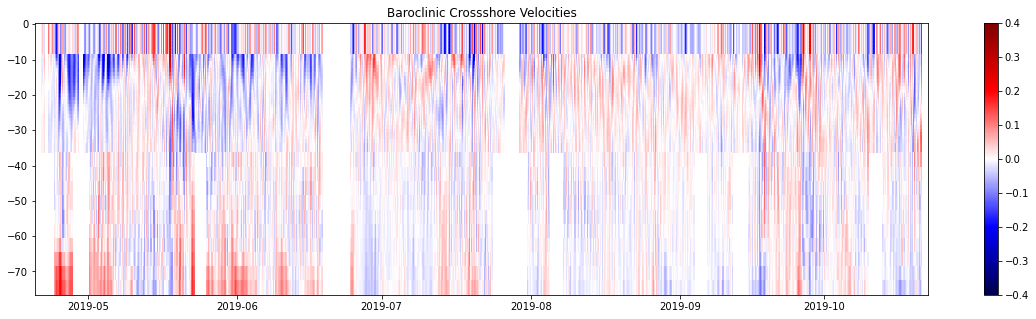

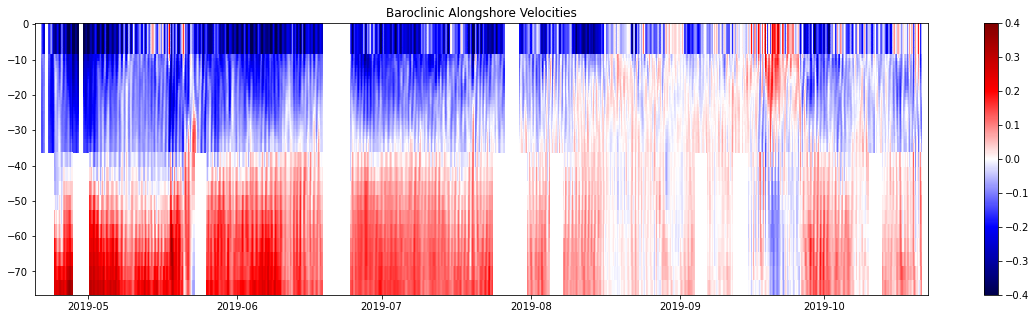

In [286]:
plt.figure(figsize=(20,5))
plt.pcolor(ds_comb['time'],-ds_comb['bin_depths_avg'],
           ds_comb['cs_bar'],cmap='seismic',shading='auto')
plt.clim([-0.4,0.4])
plt.title('Baroclinic Crossshore Velocities')
plt.colorbar()

plt.figure(figsize=(20,5))
plt.pcolor(ds_comb['time'],-ds_comb['bin_depths_avg'],
           ds_comb['as_bar'],cmap='seismic',shading='auto')
plt.clim([-0.4,0.4])
plt.title('Baroclinic Alongshore Velocities')
plt.colorbar()

### Calculate and plot sea surface transport and surface layer depth

In [287]:
good = (~np.isnan(ds_comb['cs_bar']))
us_comb, zs_comb = ts.surface_transport(ds_comb['cs_bar'].where(good).T,-ds_comb['bin_depths_avg'],ds_comb['sea_surface'])
ds_comb['us_comb'] = (['time'], us_comb) 
ds_comb['zs_comb'] = (['time'], zs_comb)

C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\physoce-0.0.2-py3.9.egg\physoce\tseries.py:531: RuntimeWarning: All-NaN slice encountered
  badi, = np.where(np.isnan(np.nanmax(xm,axis=1)))


Text(0.5, 1.0, 'First zero crossing')

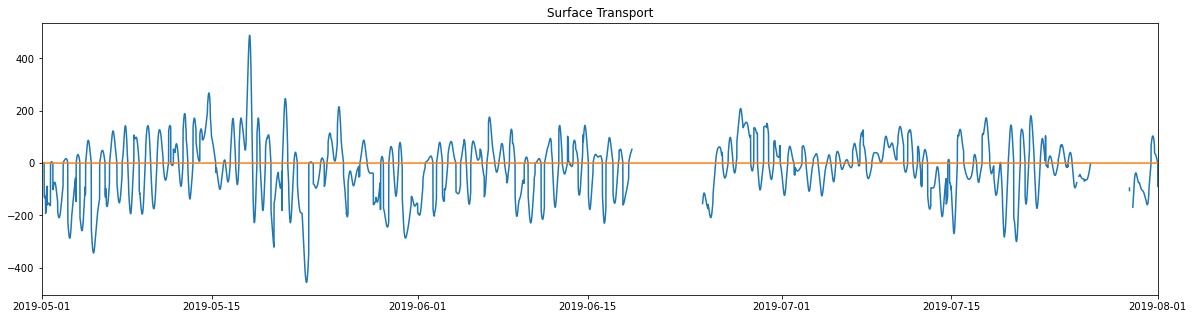

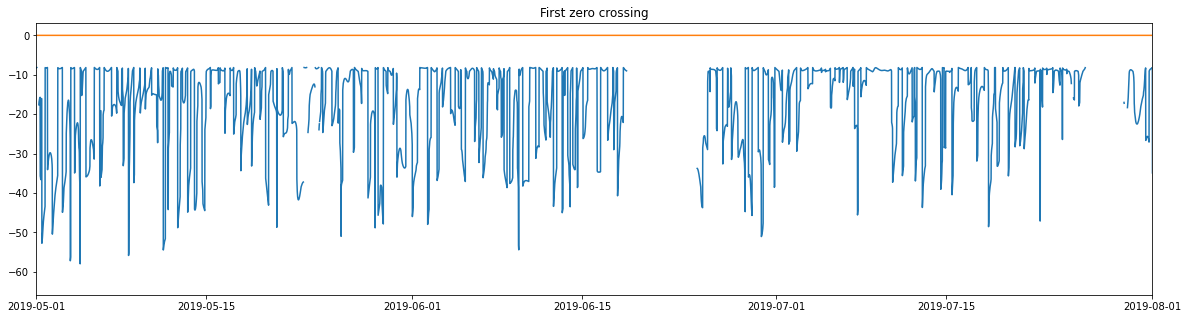

In [288]:
good_us = (~np.isnan(ds_comb['us_comb']))
good_zs = (~np.isnan(ds_comb['zs_comb']))

plt.figure(figsize=(20,5))
plt.plot(ds_comb['time'],ds_comb['us_comb'].where(good_us)*100)
#plt.plot(ds['time'],us,'--')
plt.plot(ds['time'],zero)
plt.xlim([t1,t2])
#plt.ylim([-0.5,0.5])
plt.title('Surface Transport')

plt.figure(figsize=(20,5))
plt.plot(ds_comb['time'],ds_comb['zs_comb'].where(good_zs))
#plt.plot(ds['time'],zs,'--')
plt.plot(ds['time'],zero)
plt.xlim([t1,t2])
#plt.ylim([-0.5,0.5])
plt.title('First zero crossing')

## Ensure no obvious errors in data set and save as a netcdf file!

In [289]:
ds_comb

<xarray.Dataset>
Dimensions:           (bin_depths_avg: 45, time: 17814)
Coordinates:
  * time              (time) datetime64[ns] 2019-04-20T00:30:00 ... 2019-10-2...
  * bin_depths_avg    (bin_depths_avg) float64 0.1479 1.148 2.148 ... 70.6 74.6
Data variables: (12/17)
    u                 (bin_depths_avg, time) float64 -0.1552 ... 0.001094
    v                 (bin_depths_avg, time) float64 -0.4895 -0.5444 ... 0.09226
    sea_surface       (time) float64 -0.7068 -0.7922 -0.8673 ... 0.3059 0.3683
    bottom_depth_avg  float64 80.72
    u_fil             (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    v_fil             (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    ...                ...
    as_fil            (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    theta             float64 64.19
    cs_bar            (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    as_bar            (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    us_comb           (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    zs_comb           (time) float64 nan nan nan nan nan ... nan nan nan nan nan

In [290]:
savepath = 'C:/Users/asche/REU21/netcdf/midshelf__comb_constant.nc'
ds_comb.to_netcdf(savepath, 'w')